Epoch 1, Loss: 0.6112343156710267
Epoch 2, Loss: 0.562088931677863
Epoch 3, Loss: 0.5343279426451772
Epoch 4, Loss: 0.49484953563660383
Epoch 5, Loss: 0.4896236630156636
Epoch 6, Loss: 0.4739864005241543
Epoch 7, Loss: 0.4736526911146939
Epoch 8, Loss: 0.46490578074008226
Epoch 9, Loss: 0.4601572039537132
Epoch 10, Loss: 0.45888081612065434
Epoch 11, Loss: 0.4554048103746027
Epoch 12, Loss: 0.4536754433065653
Epoch 13, Loss: 0.45609924639575183
Epoch 14, Loss: 0.4546019434928894
Epoch 15, Loss: 0.4464869841467589
Epoch 16, Loss: 0.4464807363692671
Epoch 17, Loss: 0.44623093656264246
Epoch 18, Loss: 0.43974298192188144
Epoch 19, Loss: 0.44073075125925243
Epoch 20, Loss: 0.4361503350082785
Epoch 21, Loss: 0.44239956024102867
Epoch 22, Loss: 0.43458539457060397
Epoch 23, Loss: 0.43269407912157476
Epoch 24, Loss: 0.4325196221470833
Epoch 25, Loss: 0.4307927628979087
Epoch 26, Loss: 0.4256040689069778
Epoch 27, Loss: 0.4291304962243885
Epoch 28, Loss: 0.42441016365773976
Epoch 29, Loss: 0.4

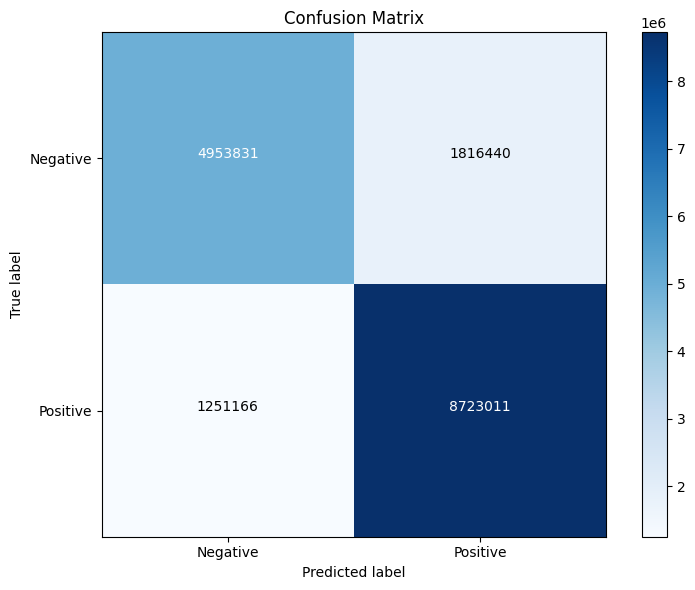

IoU: 0.739826507807013
F1 Score: 0.8504600941383943


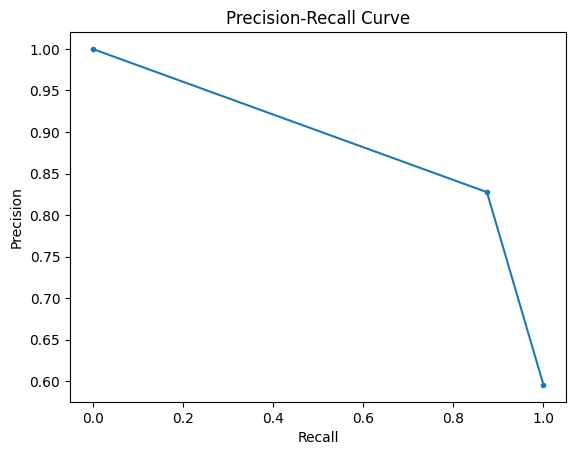

In [6]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, f1_score, jaccard_score
import matplotlib.pyplot as plt

# Класс для загрузки данных
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Трансформация в тензор
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Перестановка осей (H, W, C) -> (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Добавляем измерение для канала маски (1, H, W)
        return image, mask

# Загрузка данных
def load_data(image_dir, mask_dir):
    images = []
    masks = []

    image_files = os.listdir(image_dir)
    
    for filename in image_files:
        base_name = filename.split('_sat_')[0] + '_'
        mask_filename = f"{base_name}mask_{filename.split('_')[2]}"
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Ошибка чтения изображения: {img_path}")
            continue

        img = cv2.resize(img, (128, 128))
        images.append(img)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Ошибка чтения маски: {mask_path}")
            continue

        mask = cv2.resize(mask, (128, 128))
        masks.append(mask)

    return np.array(images), np.array(masks)

# Определение архитектуры U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # Энкодер
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)

        # Декодер
        u1 = self.up1(c3)
        u1 = torch.cat([u1, c2], dim=1)
        u1 = self.conv4(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, c1], dim=1)
        u2 = self.conv5(u2)

        return torch.sigmoid(self.final(u2))

# Путь к данным
image_dir = '/home/aleksey/DS_bootcamp/area/Forest Segmented/images'
mask_dir = '/home/aleksey/DS_bootcamp/area/Forest Segmented/masks'

# Загрузка данных
X, y = load_data(image_dir, mask_dir)

# Нормализация
X = X.astype('float32') / 255.0
y = (y.astype('float32') / 255.0).reshape(-1, 128, 128)

# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание датасетов
train_dataset = SegmentationDataset(X_train, y_train)
val_dataset = SegmentationDataset(X_val, y_val)

# Загрузка данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Обучение модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
for epoch in range(30):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Убираем лишнее .unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, masks)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")

# Сохранение модели
torch.save(model.state_dict(), 'unet_model.pth')
print("Модель сохранена в файл 'unet_model.pth'")

# Оценка на валидационной выборке
model.eval()
val_loss = 0.0
all_predictions = []
all_targets = []
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()

        preds = (outputs > 0.5).float()
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(masks.cpu().numpy())

print(f"Validation Loss: {val_loss/len(val_loader)}")

# Приведение масок в плоский вид
all_predictions = np.concatenate(all_predictions).flatten()
all_targets = np.concatenate(all_targets).flatten()

# Вывод метрик
cm = confusion_matrix(all_targets > 0.5, all_predictions > 0.5)

# Отображение классификационного отчета
print(classification_report(all_targets > 0.5, all_predictions > 0.5))
print(f"Confusion Matrix:\n{cm}")

# Визуализация матрицы путаницы
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])

# Вывод значений в ячейках матрицы
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Дополнительные метрики
iou = jaccard_score(all_targets > 0.5, all_predictions > 0.5)
print(f"IoU: {iou}")

# F1 Score
f1 = f1_score(all_targets > 0.5, all_predictions > 0.5)
print(f"F1 Score: {f1}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_targets > 0.5, all_predictions > 0.5)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()




